In [1]:
# startup
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline
import babysmurf as bs

In [2]:
plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=24) #fontsize of the title
plt.rc('axes', labelsize=18) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend

In [3]:
# define resonator parameters similar to typical umux100k chips from NIST
fres = 5.5e9 # 5.5GHz
Qtot = 4.e4 # aim for bandwidth of 100kHz
Qc = 5.e4 # all real for now, not asymmetric

fvec = np.linspace(fres-500.e3,fres+500.e3,int(1e3)) # 1kHz spacing on fvec

a,p = bs.make_res_s21(fres,fvec,Qtot,Qc)

Text(0, 0.5, 'Hz/rtHz')

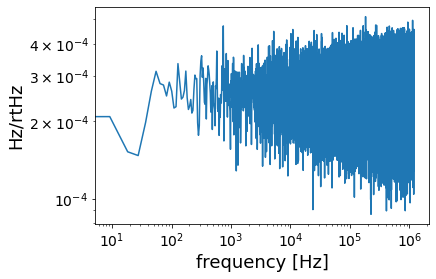

In [4]:
# generate a noise spectrum, it doesn't really matter the amplitude

# first generate a noise spectrum with 2.4MHz rolloff
noise = np.random.rand(2**20) 
ff,pxx = scipy.signal.welch(noise,fs=2.4e6,nperseg=2**18)

# plot it
plt.loglog(ff,np.sqrt(pxx))
plt.xlabel('frequency [Hz]')
plt.ylabel('Hz/rtHz')

Text(0, 0.5, 'frequency [Hz]')

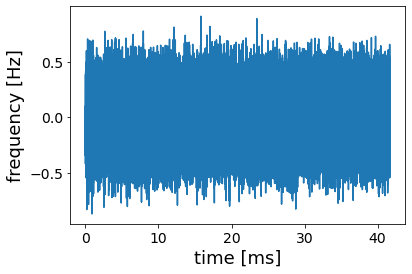

In [5]:
# now draw a tod from this
nsamp = int(1e5)
noise_tod = bs.gen_noise_tod(np.sqrt(pxx),ff,nsamp)
tvec = np.linspace(0,nsamp/2.4e6,nsamp,endpoint=False)
plt.plot(tvec*1e3,noise_tod)
plt.xlabel('time [ms]')
plt.ylabel('frequency [Hz]')

Text(0.5, 1.0, 'SQUID-Modulated Resonance Frequency')

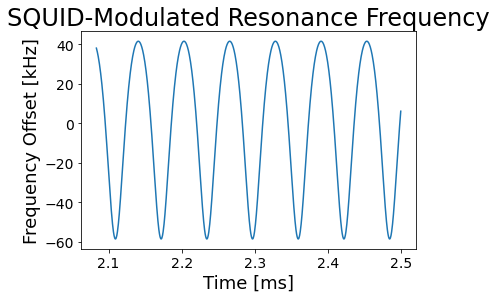

In [6]:
# that looks reasonable. Make a frequency signal with no detector input
tvec = np.linspace(0,1,100) # create full second of data
sig = np.zeros(np.shape(tvec))
squid = bs.make_squid_curve(0.33,100.e3) # lambda = 0.33, 100kHz peak to peak frequency swing

m,t,ph = bs.make_measured_signal(tvec,sig,squid,reset_rate=4.e3) # take nphi0=4, fsamp = 2.4MHz as defaults, but 4kHz reset rate as is common

# plot a subset of the output
fig,ax = plt.subplots(1,1)
ax.plot(t[5000:6000] * 1e3,m[5000:6000] * 1e-3)
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Frequency Offset [kHz]')
ax.set_title('SQUID-Modulated Resonance Frequency')

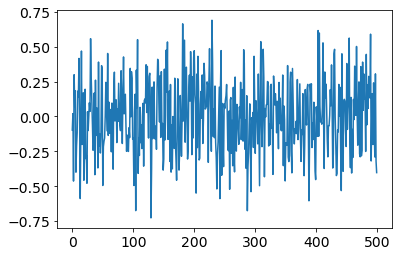

In [7]:
# now add noise
m_noise = bs.add_noise(m,ff,np.sqrt(pxx))
plt.plot(m_noise[5000:5500] - np.ravel(m[5000:5500]))

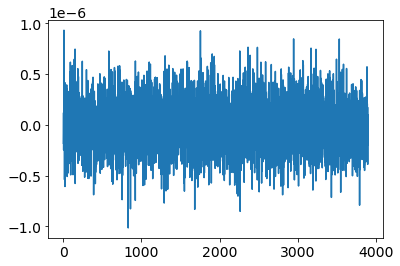

In [8]:
# attempt to demodulate
dd,_,_,_,_ = bs.lms_fit_demod_meas(m_noise,reset_rate=4.e3,gain=1/8)
plt.plot(dd[100:] - np.mean(dd[100:]))

In [9]:
# and take the psd again
ff_d,pxx_d = scipy.signal.welch(dd[:,0],fs=4.e3,nperseg=2000)

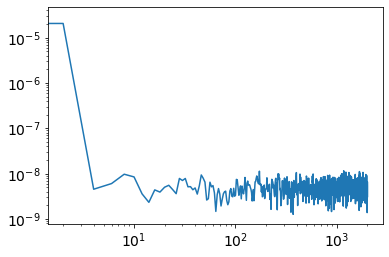

In [10]:
plt.loglog(ff_d,np.sqrt(pxx_d))

In [11]:
# now vary the stop frac
stop_frac = [1.,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2]
demods = np.zeros((len(dd),len(stop_frac)))
for idx,frac in enumerate(stop_frac):
    print(idx)
    dm,_,_,_,_ = bs.lms_fit_demod_meas(m_noise,reset_rate=4.e3,gain=1/8,blank=[0,frac])
    demods[:,idx] = np.ravel(dm)

0
1
2
3
4
5
6
7
8


In [40]:
nperseg = 500
pxx_array = np.zeros((nperseg//2 + 1,len(stop_frac)))
for ii in range(len(stop_frac)):
    ff_array,pxx_array[:,ii] = scipy.signal.welch(demods[:,ii],fs=4.e3,nperseg=nperseg)

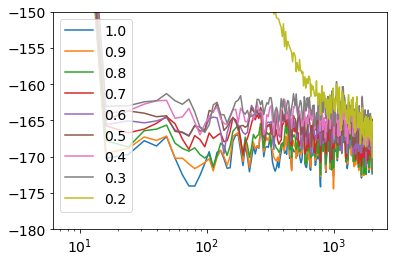

In [41]:
for ii in range(len(stop_frac)):
    plt.semilogx(ff_array,10.*np.log10(pxx_array[:,ii] / np.mean(demods[:,ii])**2) ,label=f'{stop_frac[ii]}')
plt.ylim([-180,-150])
plt.legend()

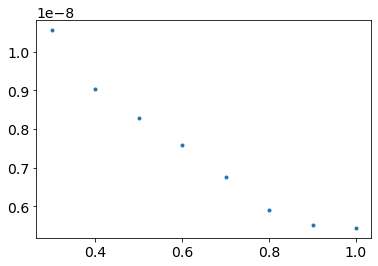

In [42]:
# try to get white noise levels
wn_level = np.zeros((len(stop_frac),))
for ii in range(len(stop_frac)):
    wn_level[ii] = np.mean(pxx_array[3:-3,ii])
plt.plot(stop_frac[:-1],np.sqrt(wn_level[:-1]),'.')

In [49]:
import matplotlib

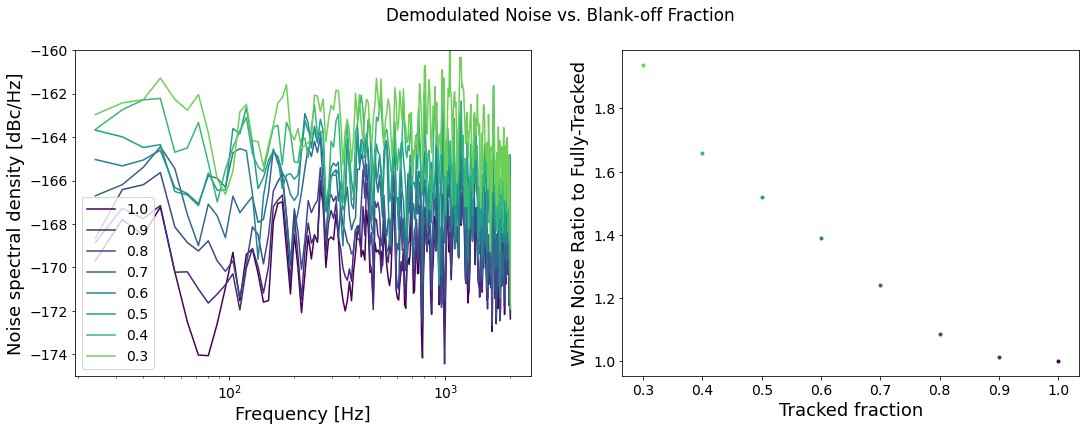

In [107]:
# neat, now put the plots together
fig,ax = plt.subplots(1,2,figsize=(18,6))
viridis=matplotlib.cm.get_cmap('viridis')
for ii in range(len(stop_frac)-1):
    ax[0].semilogx(ff_array[3:],10.*np.log10(pxx_array[3:,ii] / np.mean(demods[:,ii])**2) ,label=f'{stop_frac[ii]}',color=viridis(ii/len(stop_frac)))
    ax[1].plot(stop_frac[ii],np.sqrt(wn_level[ii]/wn_level[0]),'.',color=viridis(ii/len(stop_frac)))
ax[0].set_ylim([-175,-160])
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('Noise spectral density [dBc/Hz]')
ax[0].legend()
#ax[1].plot(stop_frac[:-1],np.sqrt(wn_level[:-1] / wn_level[0]),'.')
ax[1].set_xlabel('Tracked fraction')
ax[1].set_ylabel('White Noise Ratio to Fully-Tracked')
plt.suptitle('Demodulated Noise vs. Blank-off Fraction')
plt.savefig('plots/aliasing.png',bbox_inches='tight',dpi=600)
plt.savefig('plots/aliasing.svg',bbox_inches='tight')

In [89]:
def integrate(squid,frac):
    deriv = np.power(np.diff(squid),2)
    integral = np.sum(deriv[:round(frac * len(squid))],0) / np.sum(deriv,0)
    return integral

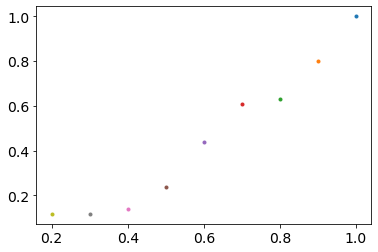

In [97]:
ints = np.zeros(len(stop_frac),)
for ii in range(len(stop_frac)):
    plt.plot(stop_frac[ii],integrate(squid,stop_frac[ii]),'.')
    ints[ii] = integrate(squid,stop_frac[ii])

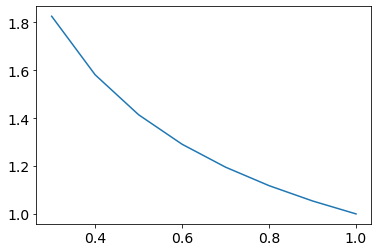

In [108]:
plt.plot(stop_frac[:-1], np.power(np.ones(len(stop_frac)-1) / stop_frac[:-1],1/2))